In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

torch.random.manual_seed(0)

# Genetic Algorithm

In [2]:
class GeneticAlgorithm():
    def __init__(self, X, y, individual_size, population_size, fitness_function, bounds, mutation_rate = 0.05, crossover_rate= 0.9, elitism = 2):
        self.X = X
        self.y = y
        self.bounds = bounds
        self.elitism = elitism
        self.individual_size = individual_size
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.fitness_function = fitness_function
        self.population = torch.stack([self._create_individual() for _ in range(self.population_size)])
    
    def _create_individual(self):
        return (torch.rand(self.individual_size) - 0.5) * self.bounds
    
    def _fitness(self, individual):
        return 1 / (self.fitness_function(individual, self.X, self.y) + 0.001)
    
    def _cross_over(self, parent1, parent2):
        child1 = parent1.clone()
        child2 = parent2.clone()
        for i in range(self.individual_size):
            if torch.rand(1) < self.crossover_rate:
                child1[:, i] = parent2[:, i]
                child2[:, i] = parent1[:, i]
        return child1.reshape((1, -1)), child2.reshape((1, -1))
    
    def _mutate(self, individual):
        for i in range(self.individual_size):
            if torch.rand(1) < self.mutation_rate:
                individual[:, i] = self._create_individual()[i]
        return individual
    
    def _select(self, sorted_population):
        idx1 = torch.randint(0, self.population_size, (1,))
        while True:
            idx2 = torch.randint(0, self.population_size, (1,))
            if idx1 != idx2:
                break
        individual_s = sorted_population[idx1]
        if idx2 < idx1:
            individual_s = sorted_population[idx2]
        return individual_s
    
    def _create_next_generation(self, gen):
        sorted_population = torch.stack(sorted(self.population, key=self._fitness, reverse=True))
        next_generation = sorted_population[:self.elitism]
        if gen % 10 == 0:
            print("Generation: ", gen, "Best fitness: ", sorted_population[0], "with fitness: ", self._fitness(sorted_population[0]))
        while next_generation.shape[0] < self.population_size:
            parent1 = self._select(sorted_population)
            parent2 = self._select(sorted_population)
            child1, child2 = self._cross_over(parent1, parent2)
            child1 = self._mutate(child1)
            child2 = self._mutate(child2)
            next_generation = torch.cat((next_generation, child1, child2), dim=0)
        return next_generation
    
    def fit(self, n_generations):
        history = []
        for gen in range(n_generations):
            history.append(self._fitness(self.population[0]))
            self.population = self._create_next_generation(gen + 1)
        return history
    
    def get_best_individual(self):
        return self.population[0]


# Advertising Data - GA for Regression

In [62]:
ad_data_df = pd.read_csv("data/advertising.csv")
ad_data_df.head()


,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


In [63]:
# convert to tensor
ad_data = torch.tensor(ad_data_df.values, dtype=torch.float32)
# devide features to X, label to y 
X, y = ad_data[:, :-1], ad_data[:, -1]
print(X.shape)
print(y.shape)

torch.Size([200, 3])
torch.Size([200])


In [65]:
# add bias to X
bias = torch.ones((X.shape[0], 1))
X_b = torch.cat((bias, X), dim=1)
print(X_b.shape)

torch.Size([200, 4])


In [66]:
def compute_loss_regression(individual, X, y):
    y_hat = X @ individual
    return torch.mean((y - y_hat) ** 2)

In [84]:
GAModel = GeneticAlgorithm(X_b, y, individual_size=X_b.shape[1], population_size=600, fitness_function=compute_loss_regression, bounds=10, mutation_rate=0.05, crossover_rate=0.9, elitism=2)
history = GAModel.fit(200)
best_population = GAModel.get_best_individual()
best_population

Generation:  10 Best fitness:  tensor([-3.7322,  0.0843,  0.3688, -0.1493]) with fitness:  tensor(0.0312)
Generation:  20 Best fitness:  tensor([-1.1382,  0.0734,  0.2198, -0.0395]) with fitness:  tensor(0.0957)
Generation:  30 Best fitness:  tensor([ 1.7260,  0.0734,  0.1618, -0.0405]) with fitness:  tensor(0.1594)
Generation:  40 Best fitness:  tensor([ 2.4033,  0.0734,  0.1450, -0.0405]) with fitness:  tensor(0.1645)
Generation:  50 Best fitness:  tensor([ 2.2154,  0.0734,  0.1450, -0.0395]) with fitness:  tensor(0.1663)
Generation:  60 Best fitness:  tensor([ 4.2551,  0.0510,  0.1450, -0.0405]) with fitness:  tensor(0.1972)
Generation:  70 Best fitness:  tensor([ 4.8820,  0.0510,  0.1450, -0.0395]) with fitness:  tensor(0.2595)
Generation:  80 Best fitness:  tensor([ 4.8090,  0.0556,  0.1450, -0.0395]) with fitness:  tensor(0.2912)
Generation:  90 Best fitness:  tensor([ 4.5790,  0.0556,  0.1450, -0.0333]) with fitness:  tensor(0.3053)
Generation:  100 Best fitness:  tensor([ 4.579

tensor([ 4.5013,  0.0551,  0.1373, -0.0159])

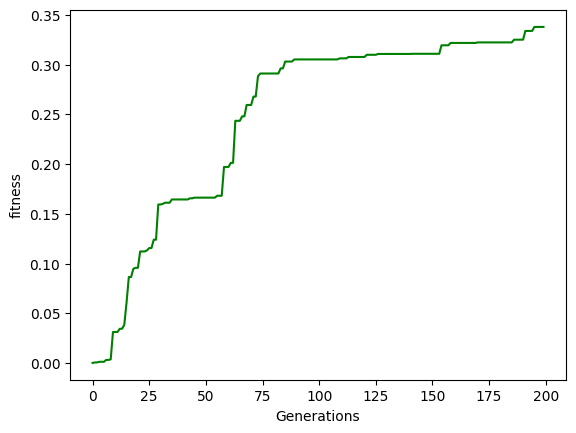

In [85]:
plt.plot(history, c='green')
plt.xlabel('Generations')
plt.ylabel('fitness')
plt.show()

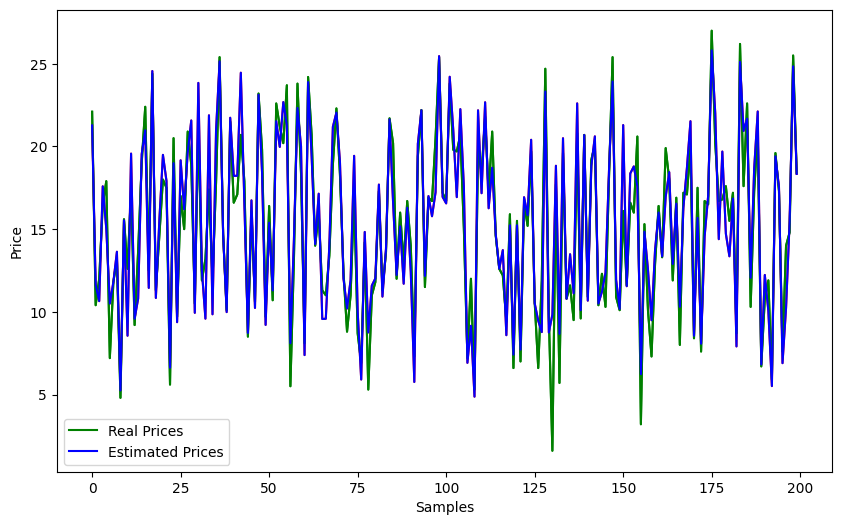

In [88]:
estimated_prices = []

for feature in X_b:        
    estimated_price = sum(c*x for x, c in zip(feature, best_population))
    estimated_prices.append(estimated_price)
         
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(y, c='green')    
plt.plot(estimated_prices, c='red')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.plot(y, c='green', label='Real Prices')
plt.plot(estimated_prices, c='blue', label='Estimated Prices')
plt.legend()
plt.show()

# Advertising Data - GA for Classification


In [22]:
iris = datasets.load_iris()
X = torch.tensor(iris.data[:100], dtype=torch.float32)
y = torch.tensor(iris.target[:100], dtype=torch.float32)
print(X.shape)
print(y.shape)

torch.Size([100, 4])
torch.Size([100])


In [23]:
# add bias to X
bias = torch.ones((X.shape[0], 1))
X_b = torch.cat((bias, X), dim=1)
print(X_b.shape)

torch.Size([100, 5])


In [20]:
def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

def compute_loss_classification(individual, X, y):
    y_hat = sigmoid(X @ individual)
    y_hat = torch.clip(y_hat, 1e-7, 1 - 1e-7)
    return torch.mean( y * torch.log(y_hat) + (1 - y) * torch.log(1 - y_hat) )
    

In [25]:
GAModel = GeneticAlgorithm(X_b, y, individual_size=X_b.shape[1], population_size=500, fitness_function=compute_loss_classification, bounds=20, mutation_rate=0.1, crossover_rate=0.9, elitism=2)
history = GAModel.fit(1000)
best_population = GAModel.get_best_individual()
best_population


Generation:  10 Best fitness:  tensor([ 9.3373, -6.7162,  0.2073,  9.9677,  0.5626]) with fitness:  tensor(5103.0127)
Generation:  20 Best fitness:  tensor([-1.6456,  0.8812, -7.0565,  9.9677, -9.6671]) with fitness:  tensor(10308.9707)
Generation:  30 Best fitness:  tensor([-1.6456,  0.8812, -7.0565,  9.9677, -8.7211]) with fitness:  tensor(68922.3828)
Generation:  40 Best fitness:  tensor([-1.6456,  0.8812, -7.0565,  9.9677, -8.6841]) with fitness:  tensor(113431.4219)
Generation:  50 Best fitness:  tensor([-1.6456,  0.8812, -7.0565,  9.9677, -8.6841]) with fitness:  tensor(113431.4219)
Generation:  60 Best fitness:  tensor([-1.6456,  0.8812, -7.0565,  9.9677, -8.6785]) with fitness:  tensor(125920.7344)
Generation:  70 Best fitness:  tensor([-1.6456,  0.8812, -7.0565,  9.9677, -8.6785]) with fitness:  tensor(125920.7344)
Generation:  80 Best fitness:  tensor([-1.6456,  0.8812, -7.0565,  9.9677, -8.6575]) with fitness:  tensor(216267.6406)
Generation:  90 Best fitness:  tensor([-1.64

tensor([ 3.8238, -0.4457, -6.4638,  8.6824, -4.1370])

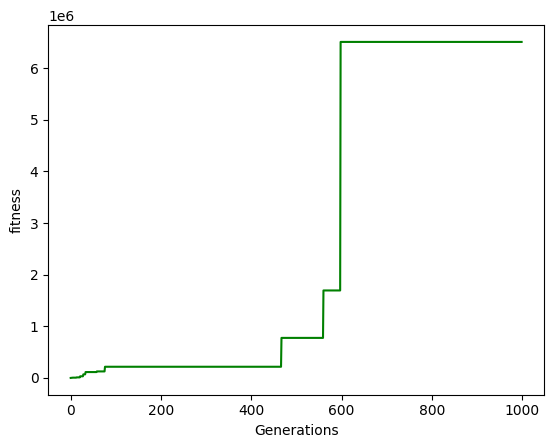

In [26]:
plt.plot(history, c='green')
plt.xlabel('Generations')
plt.ylabel('fitness')
plt.show()

In [28]:

preds = sigmoid(X_b @ best_population)
preds = torch.round(preds)
print(preds)
print(y)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


<function matplotlib.pyplot.show(close=None, block=None)>

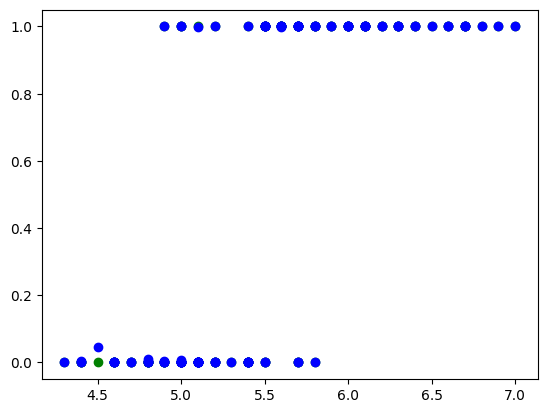

In [35]:
estimated_prices = []

for feature in X_b:        
    estimated_price = sigmoid(sum(c*x for x, c in zip(feature, best_population)))
    estimated_prices.append(estimated_price)
         
plt.scatter(X_b[:,1], y, c='green', label='Real Prices')
plt.scatter(X_b[:,1], estimated_prices, c='blue', label='Estimated Prices')
plt.show